In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from joblib import Parallel, delayed

In [2]:
# Setting matplotlib style
style.use('ggplot')

In [35]:
state_shutdown = pd.read_csv('./data/shutdown_data/IL_full_shutdown.csv')

In [38]:
# Keeping only relevant columns for plotting
state_shutdown_df = state_shutdown.copy()[['username', 'text', 'date', 'city', 'state', 'month', 'day']]

In [39]:
# Need date to be in datetime!
state_shutdown_df['date'] = pd.to_datetime(state_shutdown_df['date'], utc=True)

In [40]:
# Creating year month day column because we'll need a way to sort dates across months
state_shutdown_df['year_month_day'] = state_shutdown_df['date'].dt.date

In [43]:
state_shutdown_df.groupby('year_month_day').count()['username']

year_month_day
2020-03-17    9208
2020-03-18    8598
2020-03-19    8245
2020-03-20    8258
2020-03-21    7750
2020-03-22    7531
2020-03-23    7448
2020-03-24    7586
2020-03-25    7386
2020-03-26    7618
2020-03-27    7263
2020-03-28    6654
2020-03-29    6590
2020-03-30    6836
Name: username, dtype: int64

In [44]:
def plot_tweets_per_day(data):
    x = sorted(data['year_month_day'].value_counts().index) # Sorted dates
    y = data.groupby('year_month_day').count()['username'] # Num tweets per day

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x, y, s=50, marker='o', color='darkred', zorder=3)
    sns.lineplot(x, y, color='red', linewidth=2.2)
    plt.axvline(x[3], color='blue') # 3rd day of search is the announcement date
    plt.title(f'Tweets per day in {data["state"][0]} surrounding Covid announcement date')
    plt.ylabel('Number of Tweets')
    plt.legend(labels=['_', 'Date shut-down announced'])
    plt.xlabel('Date');

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000246C6492308> has a label of '_' which cannot be automatically added to the legend.
  # This is added back by InteractiveShellApp.init_path()


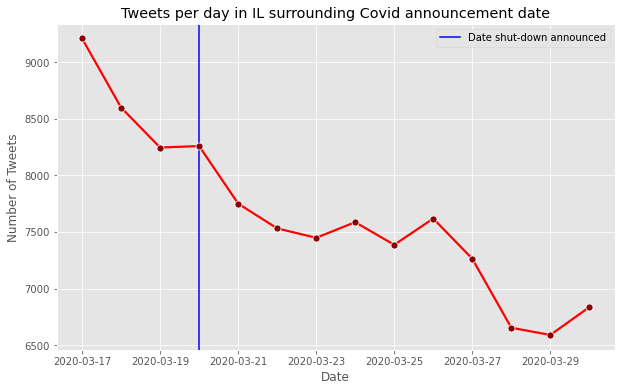

In [45]:
plot_tweets_per_day(state_shutdown_df)

Tweet activity steadily decreased in the weeks following the announcement of the shut-down in Illinois on **March 20, 2020**

In [46]:
def plot_top_and_bottom_tweeting_cities(data):
    top_tweeting_cities = data.groupby('city').count()['username'].sort_values().tail(10)
    bottom_tweeting_cities = data.groupby('city').count()['username'].sort_values().head(10)
    
    fig, ax = plt.subplots(nrows=2, figsize=(10, 12))
    
    top_tweeting_cities.plot(kind='barh',
                         x=top_tweeting_cities.index,
                         y=top_tweeting_cities.values,
                         ax=ax[0],
                         color='darkred')

    ax[0].set_title(f'Top 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[0].set_ylabel('City Name', size=16)
    ax[0].set_xlabel('Number of Tweets', size=16)
    ax[0].set_yticklabels([label.title() for label in top_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12);
    
    bottom_tweeting_cities.plot(kind='barh',
                     x=bottom_tweeting_cities.index,
                     y=bottom_tweeting_cities.values,
                     ax=ax[1],
                     color='darkblue')

    ax[1].set_title(f'Bottom 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[1].set_ylabel('City Name', size=16)
    ax[1].set_xlabel('Number of Tweets', size=16)
    ax[1].set_yticklabels([label.title() for label in bottom_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12)
    plt.tight_layout();

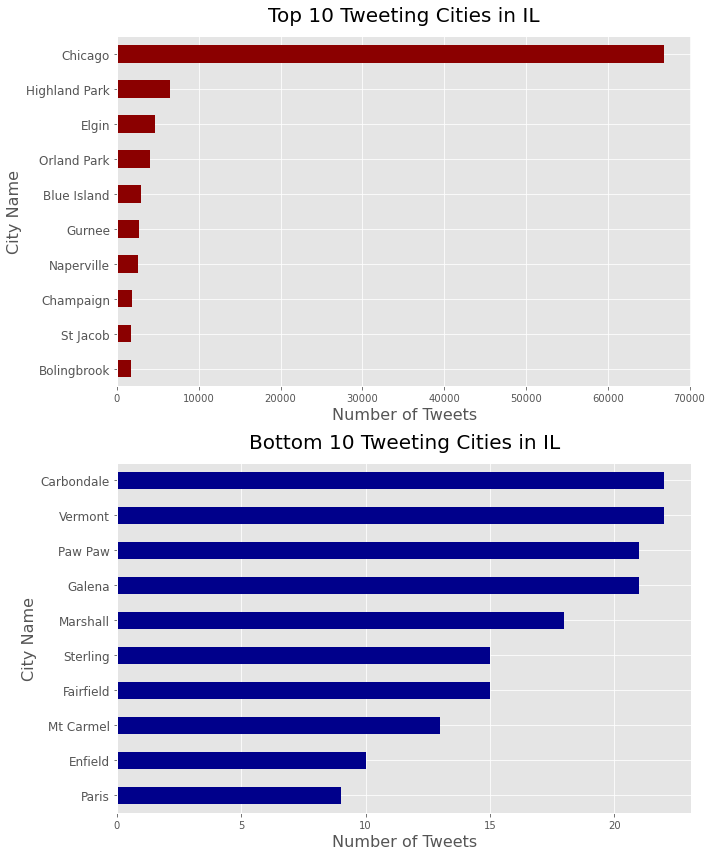

In [47]:
plot_top_and_bottom_tweeting_cities(state_shutdown_df)

**Note the drastic difference in scale!** The top three tweeting regions are Chicago, Highland Park, and Elgin. Note that these may not be precise city areas, but regions, as our collection method involved the radius surrounding a city.

## **Plotting a city's tweets per day**
Now let's take a look at an individual city's tweets per day

In [68]:
city_tweets_per_day = state_shutdown_df.groupby(['city', 'year_month_day']).count()[['username']]

In [69]:
city_tweets_per_day.T['chicago'].T.index

Index([2020-03-17, 2020-03-18, 2020-03-19, 2020-03-20, 2020-03-21, 2020-03-22,
       2020-03-23, 2020-03-24, 2020-03-25, 2020-03-26, 2020-03-27, 2020-03-28,
       2020-03-29, 2020-03-30],
      dtype='object', name='year_month_day')

In [70]:
def plot_city_tweets_per_day(data, city):
    '''
    Need to have "state_shutdown_df" defined
    '''
    sort_dates = sorted(data['year_month_day'].value_counts().index) # Sorted dates
    city_tweets_per_day = data.groupby(['city', 'year_month_day']).count()[['username']]
    city_tweets_per_day.T[city].T.plot(figsize=(10, 6), linewidth=2.2, marker='o')
    plt.title(f'Tweets Over Time in {city.title()}')
    plt.xlabel('Date')
    plt.ylabel('Number of Tweets')
    plt.axvline(sort_dates[3], color='darkblue')
    plt.legend(['_', 'Date of shutdown announcement']);

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000246C64E5B08> has a label of '_' which cannot be automatically added to the legend.
  if sys.path[0] == '':


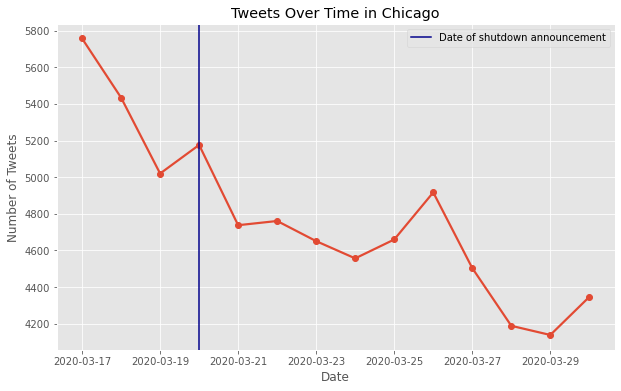

In [71]:
plot_city_tweets_per_day(state_shutdown_df, 'chicago')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000246CC3ABE08> has a label of '_' which cannot be automatically added to the legend.
  if sys.path[0] == '':


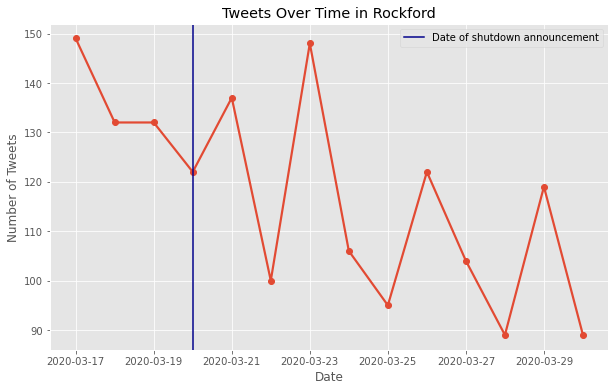

In [72]:
plot_city_tweets_per_day(state_shutdown_df, 'rockford')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000246CBF36208> has a label of '_' which cannot be automatically added to the legend.
  if sys.path[0] == '':


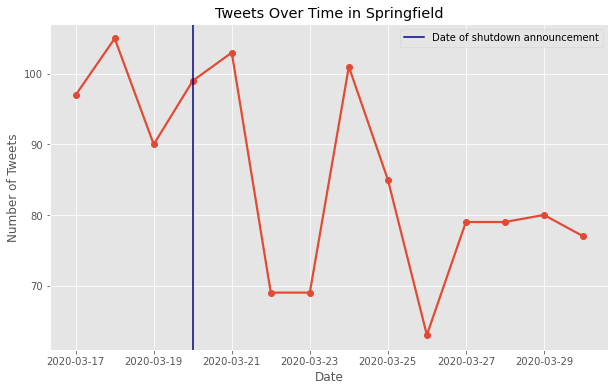

In [73]:
plot_city_tweets_per_day(state_shutdown_df, 'springfield')

## **Creating a list of the most used words so we can refine down our searches**

On our intial round of scraping, we went with no search query and our scraping was going to take too long. We decided to restrict our searches by applying some of the top used **general** and **Covid-specific** terms.

In [57]:
stop_words = ['http', 'https', 'igshid', 'becau']

In [58]:
def tokenize_and_stem(text, stemmer=True):
    '''
    This does more than just tokenize and stem! The code removes links and
    html artifacts and is great for dirty data scraped from Reddit.
    
    Needs to be run within a loop to work properly.
    '''
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]

    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    
    # Stem the tokens
    p_stemmer = PorterStemmer()
    return [p_stemmer.stem(i) for i in tokens]

def tokenize(text):
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]
    
    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    return tokens

In [59]:
custom_sw = stopwords.words('english') + stop_words
processed_sw = tokenize_and_stem(' '.join(custom_sw))

In [60]:
cvec_processed_sw = tokenize(' '.join(custom_sw))

cvec = CountVectorizer(stop_words=custom_sw, tokenizer=tokenize)
cvec_fit = cvec.fit(state_shutdown_df['text'])
cvec_transform = cvec.transform(state_shutdown_df['text'])

cvec_df = pd.DataFrame(cvec_transform.todense(),
                 columns=cvec_fit.get_feature_names())

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


,0,00,000,0000,00000,000000,000000001,000069,0001,0007,...,𝕃𝕒𝕤𝕒𝕘𝕟𝕒,𝕄𝕖𝕩𝕚𝕔𝕒𝕟,𝕘𝕪𝕡𝕤𝕪𝕔𝕠𝕣𝕟𝕖𝕣,𝕚𝕓,𝕟𝕖𝕥,𝘬𝘪𝘯𝘥𝘢𝘢𝘢𝘢𝘢,𝙡𝙪𝙘𝙠𝙮𝙗𝙖𝙣𝙙𝙞𝙩,𝙷𝙰𝙿𝙿𝚈,𝚃𝙷𝙰𝙽𝙺,𝚈𝙾𝚄
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
top_words_cvec = {}
for column in tqdm(cvec_df.columns):
    top_words_cvec[column] = cvec_df[column].sum()

most_freq_cvec = pd.DataFrame(sorted(top_words_cvec.items(), key = lambda x: x[1], reverse=True))

100%|██████████| 78579/78579 [10:55<00:00, 119.89it/s]


In [67]:
most_freq_cvec.to_csv('./data/top_words_cvec_il.csv', index=False)

In [77]:
most_freq_cvec.head(20)

,0,1
0,get,16004
1,one,13366
2,people,13364
3,time,13070
4,know,11110
5,day,11023
6,need,9883
7,go,9503
8,like,8606
9,going,8078


After removing stop words, **quarantine** and **coronavirus** appear in the top 20 most used words. This means a lot of people are talking about it on Twitter. We can't really tell anything about the sentiment, though, based on the top words. We'll get to that in a later notebook, though

## **What's next?**

Next, we'll be getting some general covid data on the states. We'll be using this data to see if there's any correlation between sentiment and covid positivity rate per state